# Nonconvex Optimization for OPF problems

### Purdue | Ruben Dario Castro Terrazas 


# Introduction

This Jupyter notebook aims to replicate the results and problem structure from the paper:

**"A Two-level ADMM Algorithm for AC OPF with Global Convergence Guarantees"**

by **Kaizhao Sun** and **Xu Andy Sun**.

In this notebook, we will:

- Implement **Vanilla ADMM** and **Two-level ADMM** algorithms for solving the AC Optimal Power Flow (ACOPF) problem.
- Compute the **equality and inequality constraints** associated with the ACOPF problem.
- Utilize the **IPOPT** solver to handle the optimization updates within the ADMM framework.

## Overview of the AC Optimal Power Flow (ACOPF) Problem

The ACOPF problem is a fundamental optimization task in power systems engineering. It seeks to determine the optimal operating conditions for an electrical power network while satisfying both physical laws and operational constraints.

### Mathematical Formulation

Consider a power network $( G(\mathcal{N}, \mathcal{E}) $), where $( \mathcal{N} $) denotes the set of buses and $( $mathcal{E} $) denotes the set of transmission lines. Let $( \delta(i) $) be the set of neighbours of $( i \in \mathcal{N} $). Let $( Y = G + jB $) denote the complex nodal admittance matrix, where $( j = \sqrt{-1} $) and $( G, B \in \mathbb{R}^{|\mathcal{N}| \times |\mathcal{N}|} $). Let $( p_i^g, q_i^g $) (resp. $( p_i^d, q_i^d $)) be the real and reactive power produced by generator(s) (resp. loads) at bus $( i $); if there is no generator (resp. load) attached to bus $( i $), then $( p_i^g, q_i^g $) (resp. $( p_i^d, q_i^d $)) are set to 0. The complex voltage $( v_i $) at bus $( i $) can be expressed by its real and imaginary parts as $( v_i = e_i + jf_i $). The rectangular formulation of AC OPF is given as:

**Objective Function:**

$$
\min_{\{p_i^g\}} \sum_{i \in \mathcal{N}} f_i(p_i^g)
\tag{1a}
$$

**Subject to:**

**Power Balance Equations (Equality Constraints):**

$$
p_i^g - p_i^d = G_{ii}(e_i^2 + f_i^2) + \sum_{j \in \delta(i)} \left( G_{ij}(e_i e_j + f_i f_j) - B_{ij}(e_i f_j - e_j f_i) \right), \quad \forall i \in \mathcal{N}
\tag{1b}
$$

$$
q_i^g - q_i^d = -B_{ii}(e_i^2 + f_i^2) + \sum_{j \in \delta(i)} \left( -B_{ij}(e_i e_j + f_i f_j) - G_{ij}(e_i f_j - e_j f_i) \right), \quad \forall i \in \mathcal{N}
\tag{1c}
$$

**Branch Flow Limits (Inequality Constraints):**

$$
p_{ij}^2 + q_{ij}^2 \leq s_{ij}^2, \quad \forall (i, j) \in \mathcal{E}
\tag{1d}
$$

**Voltage Magnitude Limits:**

$$
v_i^2 \leq e_i^2 + f_i^2 \leq \bar{v}_i^2, \quad \forall i \in \mathcal{N}
\tag{1e}
$$

**Generator Capacity Limits:**

$$
\underline{p}_i^g \leq p_i^g \leq \bar{p}_i^g, \quad \underline{q}_i^g \leq q_i^g \leq \bar{q}_i^g, \quad \forall i \in \mathcal{N}
\tag{1f}
$$

**Where:**

$$
p_{ij} = -G_{ij}(e_i^2 + f_i^2 - e_i e_j - f_i f_j) - B_{ij}(e_i f_j - e_j f_i)
\tag{2a}
$$

$$
q_{ij} = B_{ij}(e_i^2 + f_i^2 - e_i e_j - f_i f_j) - G_{ij}(e_i f_j - e_j f_i)
\tag{2b}
$$

**Variables:**

- $p_i^g,\, q_i^g$: Active and reactive power generation at bus $i$.
- $p_i^d,\, q_i^d$: Active and reactive power demand at bus $i$.
- $e_i,\, f_i$: Real and imaginary parts of the voltage at bus $i$.
- $v_i,\, \bar{v}_i$: Minimum and maximum voltage magnitude limits at bus $i$.
- $\underline{p}_i^g,\, \bar{p}_i^g$: Minimum and maximum active power generation limits at bus $i$.
- $\underline{q}_i^g,\, \bar{q}_i^g$: Minimum and maximum reactive power generation limits at bus $i$.
- $G_{ij},\, B_{ij}$: Conductance and susceptance of the line between buses $i$ and $j$.
- $\mathcal{N}$: Set of buses (nodes) in the network.
- $\delta(i)$: Set of buses connected to bus $i$.
- $\mathcal{E}$: Set of edges (lines) in the network.
- $s_{ij}$: Apparent power flow limit for line $(i, j)$.
- $p_{ij},\, q_{ij}$: Active and reactive power flows from bus $i$ to bus $j$.

**Objective Function Explanation**

The objective is to minimize the total generation cost:

$$
\min_{\{p_i^g\}} \sum_{i \in \mathcal{N}} f_i(p_i^g)
$$

where $f_i(p_i^g)$ is the cost function of the generator at bus $i$, typically modeled as:

$$
f_i(p_i^g) = a_i (p_i^g)^2 + b_i p_i^g + c_i
$$

**Constraints Explanation**

- **Power Balance Equations (1b, 1c):** Ensure that the generated power meets the demand and adheres to the network's physical laws (Kirchhoff's laws).
- **Branch Flow Limits (1d):** Ensure that the power flow on each transmission line does not exceed its thermal limit.
- **Voltage Magnitude Limits (1e):** Maintain the voltage magnitude at each bus within acceptable operational limits.
- **Generator Capacity Limits (1f):** Ensure that generators operate within their specified capacity ranges.

## IPOPT Solver

**IPOPT (Interior Point OPTimizer)** is a software package designed for large-scale nonlinear optimization problems. It is particularly well-suited for solving the type of nonlinear, nonconvex problems encountered in ACOPF.

### Problem Structure for IPOPT

IPOPT solves optimization problems of the form:

$$
\begin{align*}
\min_{x} \quad & f(x) \\
\text{subject to} \quad & g_{\text{L}} \leq g(x) \leq g_{\text{U}} \\
& x_{\text{L}} \leq x \leq x_{\text{U}}
\end{align*}
$$

**Features of IPOPT**

- **Interior Point Method:** Utilizes a primal-dual interior point algorithm, which is efficient for handling large-scale and sparse problems.
- **Derivative Information:** Can exploit first and second derivatives (gradients and Hessians) provided by the user or estimated via finite differences.
- **Flexibility:** Supports equality and inequality constraints, variable bounds, and can handle nonconvex problems.

### Application in This Notebook

In this notebook, IPOPT will be used to solve the optimization subproblems arising in the ADMM iterations for the ACOPF problem:

- **Local Updates:** During each iteration of ADMM, local optimization problems are solved using IPOPT to update the variables associated with each agent or region.
- **Handling Nonlinear Constraints:** IPOPT efficiently manages the nonlinear equality and inequality constraints inherent in the ACOPF problem.
- **Integration with ADMM:** By integrating IPOPT within the ADMM framework, we aim to leverage its optimization capabilities to achieve convergence to a feasible and optimal solution.

---

**Note:** The Alternating Direction Method of Multipliers (ADMM) algorithms, including the Vanilla and Two-level versions, will be detailed in subsequent sections of the notebook.


### Import libraries and dependencies

In [1]:
from os.path import join
import numpy as np
# import the solver and solver options from pypower
#from pypower.api import runopf, ppoption
import jax.numpy as jnp
from pypower.loadcase import loadcase
from pypower.ext2int import ext2int
from pypower.makeYbus import makeYbus

## Preparing the Data

For the following sections, we will be working with Test Case 5 PJM, which can be obtained from the [Power Grid Library - Optimal Power Flow](https://github.com/power-grid-lib/pglib-opf) repository 

We can read the test data in two ways:

* Use  the `read_data_pglib.py` file to execute the .m files
* Use the test cases from the Pypower library

### Test case 5 PJM

In [2]:
"""
net ={'baseMVA': 100.0,
 'bus': np.array([[  0.  ,   2.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ],
        [  1.  ,   1.  , 300.  ,  98.61,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ],
        [  2.  ,   2.  , 300.  ,  98.61,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ],
        [  3.  ,   3.  , 400.  , 131.47,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ],
        [  4.  ,   2.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ]]),
 'gen': np.array([[   0. ,   20. ,    0. ,   30. ,  -30. ,    1. ,  100. ,    1. ,
           40. ,    0. ],
        [   1. ,   85. ,    0. ,  127.5, -127.5,    1. ,  100. ,    1. ,
          170. ,    0. ],
        [   2. ,  260. ,    0. ,  390. , -390. ,    1. ,  100. ,    1. ,
          520. ,    0. ],
        [   3. ,  100. ,    0. ,  150. , -150. ,    1. ,  100. ,    1. ,
          200. ,    0. ],
        [   4. ,  300. ,    0. ,  450. , -450. ,    1. ,  100. ,    1. ,
          600. ,    0. ]]),
 'gencost': np.array([[ 2.,  0.,  0.,  3.,  0., 14.,  0.],
        [ 2.,  0.,  0.,  3.,  0., 15.,  0.],
        [ 2.,  0.,  0.,  3.,  0., 30.,  0.],
        [ 2.,  0.,  0.,  3.,  0., 40.,  0.],
        [ 2.,  0.,  0.,  3.,  0., 10.,  0.]]),
 'branch': np.array([[ 0.000e+00,  1.000e+00,  2.810e-03,  2.810e-02,  7.120e-03,
          4.000e+02,  4.000e+02,  4.000e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 0.000e+00,  3.000e+00,  3.040e-03,  3.040e-02,  6.580e-03,
          4.260e+02,  4.260e+02,  4.260e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 0.000e+00,  4.000e+00,  6.400e-04,  6.400e-03,  3.126e-02,
          4.260e+02,  4.260e+02,  4.260e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.000e+00,  2.000e+00,  1.080e-03,  1.080e-02,  1.852e-02,
          4.260e+02,  4.260e+02,  4.260e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 2.000e+00,  3.000e+00,  2.970e-03,  2.970e-02,  6.740e-03,
          4.260e+02,  4.260e+02,  4.260e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 3.000e+00,  4.000e+00,  2.970e-03,  2.970e-02,  6.740e-03,
          2.400e+02,  2.400e+02,  2.400e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01]])}
"""


"\nnet ={'baseMVA': 100.0,\n 'bus': np.array([[  0.  ,   2.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,\n           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ],\n        [  1.  ,   1.  , 300.  ,  98.61,   0.  ,   0.  ,   1.  ,   1.  ,\n           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ],\n        [  2.  ,   2.  , 300.  ,  98.61,   0.  ,   0.  ,   1.  ,   1.  ,\n           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ],\n        [  3.  ,   3.  , 400.  , 131.47,   0.  ,   0.  ,   1.  ,   1.  ,\n           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ],\n        [  4.  ,   2.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,\n           0.  , 230.  ,   1.  ,   1.1 ,   0.9 ]]),\n 'gen': np.array([[   0. ,   20. ,    0. ,   30. ,  -30. ,    1. ,  100. ,    1. ,\n           40. ,    0. ],\n        [   1. ,   85. ,    0. ,  127.5, -127.5,    1. ,  100. ,    1. ,\n          170. ,    0. ],\n        [   2. ,  260. ,    0. ,  390. , -390. ,    1. ,  100. ,    1. ,\n          520. ,    0. ],\n        [   3. ,  100.

### Test case 30 IEEE

In [3]:
net = {'baseMVA': 100.0,
 'bus': np.array([[  0.  ,   3.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 132.  ,   1.  ,   1.06,   0.94],
        [  1.  ,   2.  ,  21.7 ,  12.7 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 132.  ,   1.  ,   1.06,   0.94],
        [  2.  ,   1.  ,   2.4 ,   1.2 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 132.  ,   1.  ,   1.06,   0.94],
        [  3.  ,   1.  ,   7.6 ,   1.6 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 132.  ,   1.  ,   1.06,   0.94],
        [  4.  ,   2.  ,  94.2 ,  19.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 132.  ,   1.  ,   1.06,   0.94],
        [  5.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 132.  ,   1.  ,   1.06,   0.94],
        [  6.  ,   1.  ,  22.8 ,  10.9 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 132.  ,   1.  ,   1.06,   0.94],
        [  7.  ,   2.  ,  30.  ,  30.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 132.  ,   1.  ,   1.06,   0.94],
        [  8.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,   1.  ,   1.  ,   1.06,   0.94],
        [  9.  ,   1.  ,   5.8 ,   2.  ,   0.  ,  19.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 10.  ,   2.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  11.  ,   1.  ,   1.06,   0.94],
        [ 11.  ,   1.  ,  11.2 ,   7.5 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 12.  ,   2.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  11.  ,   1.  ,   1.06,   0.94],
        [ 13.  ,   1.  ,   6.2 ,   1.6 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 14.  ,   1.  ,   8.2 ,   2.5 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 15.  ,   1.  ,   3.5 ,   1.8 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 16.  ,   1.  ,   9.  ,   5.8 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 17.  ,   1.  ,   3.2 ,   0.9 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 18.  ,   1.  ,   9.5 ,   3.4 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 19.  ,   1.  ,   2.2 ,   0.7 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 20.  ,   1.  ,  17.5 ,  11.2 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 21.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 22.  ,   1.  ,   3.2 ,   1.6 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 23.  ,   1.  ,   8.7 ,   6.7 ,   0.  ,   4.3 ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 24.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 25.  ,   1.  ,   3.5 ,   2.3 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 26.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 27.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  , 132.  ,   1.  ,   1.06,   0.94],
        [ 28.  ,   1.  ,   2.4 ,   0.9 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94],
        [ 29.  ,   1.  ,  10.6 ,   1.9 ,   0.  ,   0.  ,   1.  ,   1.  ,
           0.  ,  33.  ,   1.  ,   1.06,   0.94]]),
 'gen': np.array([[  0. , 135.5,   5. ,  10. ,   0. ,   1. , 100. ,   1. , 271. ,
           0. ],
        [  1. ,  46. ,   3. ,  46. , -40. ,   1. , 100. ,   1. ,  92. ,
           0. ],
        [  4. ,   0. ,   0. ,  40. , -40. ,   1. , 100. ,   1. ,   0. ,
           0. ],
        [  7. ,   0. ,  15. ,  40. , -10. ,   1. , 100. ,   1. ,   0. ,
           0. ],
        [ 10. ,   0. ,   9. ,  24. ,  -6. ,   1. , 100. ,   1. ,   0. ,
           0. ],
        [ 12. ,   0. ,   9. ,  24. ,  -6. ,   1. , 100. ,   1. ,   0. ,
           0. ]]),
 'gencost': np.array([[ 2.      ,  0.      ,  0.      ,  3.      ,  0.      , 18.421528,
          0.      ],
        [ 2.      ,  0.      ,  0.      ,  3.      ,  0.      , 52.182254,
          0.      ],
        [ 2.      ,  0.      ,  0.      ,  3.      ,  0.      ,  0.      ,
          0.      ],
        [ 2.      ,  0.      ,  0.      ,  3.      ,  0.      ,  0.      ,
          0.      ],
        [ 2.      ,  0.      ,  0.      ,  3.      ,  0.      ,  0.      ,
          0.      ],
        [ 2.      ,  0.      ,  0.      ,  3.      ,  0.      ,  0.      ,
          0.      ]]),
 'branch': np.array([[ 0.000e+00,  1.000e+00,  1.920e-02,  5.750e-02,  5.280e-02,
          1.380e+02,  1.380e+02,  1.380e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 0.000e+00,  2.000e+00,  4.520e-02,  1.652e-01,  4.080e-02,
          1.520e+02,  1.520e+02,  1.520e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.000e+00,  3.000e+00,  5.700e-02,  1.737e-01,  3.680e-02,
          1.390e+02,  1.390e+02,  1.390e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 2.000e+00,  3.000e+00,  1.320e-02,  3.790e-02,  8.400e-03,
          1.350e+02,  1.350e+02,  1.350e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.000e+00,  4.000e+00,  4.720e-02,  1.983e-01,  4.180e-02,
          1.440e+02,  1.440e+02,  1.440e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.000e+00,  5.000e+00,  5.810e-02,  1.763e-01,  3.740e-02,
          1.390e+02,  1.390e+02,  1.390e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 3.000e+00,  5.000e+00,  1.190e-02,  4.140e-02,  9.000e-03,
          1.480e+02,  1.480e+02,  1.480e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 4.000e+00,  6.000e+00,  4.600e-02,  1.160e-01,  2.040e-02,
          1.270e+02,  1.270e+02,  1.270e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 5.000e+00,  6.000e+00,  2.670e-02,  8.200e-02,  1.700e-02,
          1.400e+02,  1.400e+02,  1.400e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 5.000e+00,  7.000e+00,  1.200e-02,  4.200e-02,  9.000e-03,
          1.480e+02,  1.480e+02,  1.480e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 5.000e+00,  8.000e+00,  0.000e+00,  2.080e-01,  0.000e+00,
          1.420e+02,  1.420e+02,  1.420e+02,  9.780e-01,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 5.000e+00,  9.000e+00,  0.000e+00,  5.560e-01,  0.000e+00,
          5.300e+01,  5.300e+01,  5.300e+01,  9.690e-01,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 8.000e+00,  1.000e+01,  0.000e+00,  2.080e-01,  0.000e+00,
          1.420e+02,  1.420e+02,  1.420e+02,  1.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 8.000e+00,  9.000e+00,  0.000e+00,  1.100e-01,  0.000e+00,
          2.670e+02,  2.670e+02,  2.670e+02,  1.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 3.000e+00,  1.100e+01,  0.000e+00,  2.560e-01,  0.000e+00,
          1.150e+02,  1.150e+02,  1.150e+02,  9.320e-01,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.100e+01,  1.200e+01,  0.000e+00,  1.400e-01,  0.000e+00,
          2.100e+02,  2.100e+02,  2.100e+02,  1.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.100e+01,  1.300e+01,  1.231e-01,  2.559e-01,  0.000e+00,
          2.900e+01,  2.900e+01,  2.900e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.100e+01,  1.400e+01,  6.620e-02,  1.304e-01,  0.000e+00,
          2.900e+01,  2.900e+01,  2.900e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.100e+01,  1.500e+01,  9.450e-02,  1.987e-01,  0.000e+00,
          3.000e+01,  3.000e+01,  3.000e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.300e+01,  1.400e+01,  2.210e-01,  1.997e-01,  0.000e+00,
          2.000e+01,  2.000e+01,  2.000e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.500e+01,  1.600e+01,  5.240e-02,  1.923e-01,  0.000e+00,
          3.800e+01,  3.800e+01,  3.800e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.400e+01,  1.700e+01,  1.073e-01,  2.185e-01,  0.000e+00,
          2.900e+01,  2.900e+01,  2.900e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.700e+01,  1.800e+01,  6.390e-02,  1.292e-01,  0.000e+00,
          2.900e+01,  2.900e+01,  2.900e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.800e+01,  1.900e+01,  3.400e-02,  6.800e-02,  0.000e+00,
          2.900e+01,  2.900e+01,  2.900e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 9.000e+00,  1.900e+01,  9.360e-02,  2.090e-01,  0.000e+00,
          3.000e+01,  3.000e+01,  3.000e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 9.000e+00,  1.600e+01,  3.240e-02,  8.450e-02,  0.000e+00,
          3.300e+01,  3.300e+01,  3.300e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 9.000e+00,  2.000e+01,  3.480e-02,  7.490e-02,  0.000e+00,
          3.000e+01,  3.000e+01,  3.000e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 9.000e+00,  2.100e+01,  7.270e-02,  1.499e-01,  0.000e+00,
          2.900e+01,  2.900e+01,  2.900e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 2.000e+01,  2.100e+01,  1.160e-02,  2.360e-02,  0.000e+00,
          2.900e+01,  2.900e+01,  2.900e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 1.400e+01,  2.200e+01,  1.000e-01,  2.020e-01,  0.000e+00,
          2.900e+01,  2.900e+01,  2.900e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 2.100e+01,  2.300e+01,  1.150e-01,  1.790e-01,  0.000e+00,
          2.600e+01,  2.600e+01,  2.600e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 2.200e+01,  2.300e+01,  1.320e-01,  2.700e-01,  0.000e+00,
          2.900e+01,  2.900e+01,  2.900e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 2.300e+01,  2.400e+01,  1.885e-01,  3.292e-01,  0.000e+00,
          2.700e+01,  2.700e+01,  2.700e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 2.400e+01,  2.500e+01,  2.544e-01,  3.800e-01,  0.000e+00,
          2.500e+01,  2.500e+01,  2.500e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 2.400e+01,  2.600e+01,  1.093e-01,  2.087e-01,  0.000e+00,
          2.800e+01,  2.800e+01,  2.800e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 2.700e+01,  2.600e+01,  0.000e+00,  3.960e-01,  0.000e+00,
          7.500e+01,  7.500e+01,  7.500e+01,  9.680e-01,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 2.600e+01,  2.800e+01,  2.198e-01,  4.153e-01,  0.000e+00,
          2.800e+01,  2.800e+01,  2.800e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 2.600e+01,  2.900e+01,  3.202e-01,  6.027e-01,  0.000e+00,
          2.800e+01,  2.800e+01,  2.800e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 2.800e+01,  2.900e+01,  2.399e-01,  4.533e-01,  0.000e+00,
          2.800e+01,  2.800e+01,  2.800e+01,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 7.000e+00,  2.700e+01,  6.360e-02,  2.000e-01,  4.280e-02,
          1.400e+02,  1.400e+02,  1.400e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01],
        [ 5.000e+00,  2.700e+01,  1.690e-02,  5.990e-02,  1.300e-02,
          1.490e+02,  1.490e+02,  1.490e+02,  0.000e+00,  0.000e+00,
          1.000e+00, -3.000e+01,  3.000e+01]])}

In [4]:
"""
from read_data_pglib import read_matpower_powergrid
dir_myFile = r'test data/PGLib OPF/feasible'
net = read_matpower_powergrid(dir_myFile)
net
"""

"\nfrom read_data_pglib import read_matpower_powergrid\ndir_myFile = r'test data/PGLib OPF/feasible'\nnet = read_matpower_powergrid(dir_myFile)\nnet\n"

In [5]:
net['baseMVA']

100.0

* $Y = G  + jB$
    * G(conductance): Measures the ability of the line to conduct electric current. It represents the real part of the admittance and indicates the power dissipation in the line due to resistance. Higher conductance implies lower energy losses.
    * B(Susceptance): Represents the imaginary part of admittance and is crucial for understanding the capacitive or inductive nature of the line. Susceptance affects the reactive power flow and voltage regulation across the line.

Calculating $G$ and $B$ is essential when computing the constraints in the following sections

In [6]:
Ybus,Yf,Yt = makeYbus(net['baseMVA'],net['bus'],net['branch'])#Admittance matrix
Ybus = Ybus.toarray()

In [7]:
demand_load = net['bus'][:,2:4] #Pg and Qg demand for each bus

pd = demand_load[:,0]
qd = demand_load[:,1]
G = jnp.array(np.real(Ybus)) #Conductance matrix
B = jnp.array(np.imag(Ybus)) #Susceptance matrix

G,B

(Array([[  6.7655163,  -5.224646 ,  -1.5408698,   0.       ,   0.       ,
           0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
           0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
           0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
           0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
           0.       ,   0.       ,   0.       ,   0.       ,   0.       ],
        [ -5.224646 ,   9.752282 ,   0.       ,  -1.7055303,  -1.1359608,
          -1.6861448,   0.       ,   0.       ,   0.       ,   0.       ,
           0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
           0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
           0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
           0.       ,   0.       ,   0.       ,   0.       ,   0.       ],
        [ -1.5408698,   0.       ,   9.736319 ,  -8.195449 ,   0.       ,
           0.       ,   0.       ,  

In [8]:
def create_S(net_branches,G,B):
    branch_data = net_branches[:,:6]
    S = np.zeros((B.shape[0], B.shape[1]))

    # Populate S matrix
    for branch in branch_data:
        fbus = int(branch[0])   # From bus (zero-based index)
        tbus = int(branch[1])  # To bus (zero-based index)
        rateA = branch[5]          # Thermal limit

        # Set thermal limits in S matrix
        S[fbus, tbus] = rateA
        S[tbus, fbus] = rateA  # Assuming the network is undirected

    return jnp.array(S)

S = create_S(net["branch"],G,B)
# Display the S matrix
print("S matrix (Thermal Capacity Limits):")
print(S)

S matrix (Thermal Capacity Limits):
[[  0. 138. 152.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [138.   0.   0. 139. 144. 139.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [152.   0.   0. 135.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0. 139. 135.   0.   0. 148.   0.   0.   0.   0.   0. 115.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0. 144.   0.   0.   0.   0. 127.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0. 139.   0. 148.   0.   0. 140. 148. 142.  53.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 149.
    0.   0.]
 [  0.   0.   0.   0. 

We define the variables

In [9]:
pg = net['gen'][:, 1]
qg = net['gen'][:, 2]

V_i = net['bus'][:, 7]
theta_i = np.radians(net['bus'][:, 8])

e = V_i  * np.cos(theta_i)
f = V_i * np.sin(theta_i)

e,f

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [10]:
branch = net['branch'][:,:2]
branch

array([[ 0.,  1.],
       [ 0.,  2.],
       [ 1.,  3.],
       [ 2.,  3.],
       [ 1.,  4.],
       [ 1.,  5.],
       [ 3.,  5.],
       [ 4.,  6.],
       [ 5.,  6.],
       [ 5.,  7.],
       [ 5.,  8.],
       [ 5.,  9.],
       [ 8., 10.],
       [ 8.,  9.],
       [ 3., 11.],
       [11., 12.],
       [11., 13.],
       [11., 14.],
       [11., 15.],
       [13., 14.],
       [15., 16.],
       [14., 17.],
       [17., 18.],
       [18., 19.],
       [ 9., 19.],
       [ 9., 16.],
       [ 9., 20.],
       [ 9., 21.],
       [20., 21.],
       [14., 22.],
       [21., 23.],
       [22., 23.],
       [23., 24.],
       [24., 25.],
       [24., 26.],
       [27., 26.],
       [26., 28.],
       [26., 29.],
       [28., 29.],
       [ 7., 27.],
       [ 5., 27.]])

In [11]:
if 'baseMVA' in net.keys():
    del net['baseMVA']

In [12]:
net['gencost'][:,0] = net['gen'][:,0] #Index each generator

In [13]:
#Transform each data structure of the net into jax numpy
for key,matrix in net.items():
    net[key] = jnp.array(matrix)

## Solve test case 30 IEEE 

We are specifying that the problem has only one regions, with **30 interior buses** and **0 boundary buses**. 

To explain the nature of the variables, we will suppose we have a problem with 5 interior buses (Test Case 5 PJM).From the code below, we see that we obtain the variable $x^1$, which is defined as the following in this case:

$$x^1 = 
\begin{bmatrix}
p^{g}_0 &q^{g}_0  & e_{0} & f_{0}\\
p^{g}_1 & q^{g}_1 &  e_{1} & f_{1}\\
p^{g}_2 & q^{g}_2 &  e_{2} & f_{2}\\
p^{g}_3 & q^{g}_3 &  e_{3} & f_{3}\\
`p^{g}_4 & q^{g}_4 &  e_{4} & f_{4}\\
\end{bmatrix}
$$

From what we can see from the data above, is that each row constains relevant data in respect to each bus $x_i^1 =(p_i^g,q_i^g,e_i,f_i)$ 

To make things easier when using the IPOPT solver, we will reshape the matrix to be a vector of dimensions 1 $× (n_v * n_b)$, where:

* $n_v$: Number of variables for each bus (4 in this case)
* $n_b$: Number of buses (5)

So the vector will look like the following

$$x^1 = (p^{g}_0,p^{g}_1 ,p^{g}_2 ,p^{g}_3 ,p^{g}_4,q^{g}_0,q^{g}_1,q^{g}_2,q^{g}_3,q^{g}_4,...,f_4)$$


In the following function, we define the bounds for each variable and generate a random sample. We can also see that the code considers a problem with multiple regions, which will be useful when applying the ADMM algorithm.

In [14]:
regions = {
    1:(set([i for i in range(30)]),{})
}
regions

{1: ({0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29},
  {})}

In [15]:
def generate_x0_bnds(net,regions):

    x_r = {}
    bnds = {}


    gen_data = jnp.array(net["gen"])
    bus_data = jnp.array(net["bus"])

    for region,buses in regions.items():

        bnds_i = []
        x_int = jnp.array(list(buses[0]))
        x_bou = jnp.array(list(buses[1]))

        pg_min_int = gen_data[x_int,:][:, 9]
        qg_min_int = gen_data[x_int,:][:, 4]
        pg_max_int = gen_data[x_int,:][:, 8]
        qg_max_int = gen_data[x_int,:][:, 3]

        #v_min_int = bus_data[x_int,:][:,12]
        v_min_int = np.zeros(len(x_int)) 
        v_max_int = bus_data[x_int,:][:,11]  


        X_int = np.zeros((4,len(x_int)))
        Bnds_int_min = np.zeros((4,len(x_int)))
        Bnds_int_max = np.zeros((4,len(x_int)))


        for j in range(len(x_int)):
            #iterates through each column
            X_int[0,j] = np.random.uniform(pg_min_int[j],pg_max_int[j],1)[0]   
            X_int[1,j] = np.random.uniform(qg_min_int[j],qg_max_int[j],1)[0]  
            X_int[2,j] = np.random.uniform(v_min_int[j],v_max_int[j],1)[0] 
            X_int[3,j] =  np.random.uniform(v_min_int[j],v_max_int[j],1)[0]

            Bnds_int_min[0,j] =  pg_min_int[j]
            Bnds_int_min[1,j] =  qg_min_int[j]
            Bnds_int_min[2,j] =  v_min_int[j]
            Bnds_int_min[3,j] =  v_min_int[j]

            Bnds_int_max[0,j] =  pg_max_int[j]
            Bnds_int_max[1,j] =  qg_max_int[j]
            Bnds_int_max[2,j] =  v_max_int[j]
            Bnds_int_max[3,j] =  v_max_int[j]

        bnds_int_min = Bnds_int_min.reshape(-1)
        bnds_int_max = Bnds_int_max.reshape(-1)
        for k in range(len(bnds_int_min)):
            bnds_i.append((float(bnds_int_min[k]),float(bnds_int_max[k])))


        #v_min_bou = bus_data[x_int,:][:,12]
        v_min_bou = np.zeros(len(x_bou))  
        v_max_bou = bus_data[x_int,:][:,11]  

        X_bound = np.zeros((2,len(x_bou)))

        Bnds_bou_min = np.zeros((2,len(x_bou)))
        Bnds_bou_max = np.zeros((2,len(x_bou)))

 
        for j in range(len(x_bou)):

            X_bound[0,j] = np.random.uniform(v_min_bou[j],v_max_bou[j],1)[0] 
            X_bound[1,j] = np.random.uniform(v_min_bou[j],v_max_bou[j],1)[0]

            Bnds_bou_min[0,j] =  v_min_bou[j]
            Bnds_bou_min[1,j] =  v_min_bou[j]

            Bnds_bou_max[0,j] =  v_max_bou[j]
            Bnds_bou_max[1,j] =  v_max_bou[j]
        
        bnds_bou_min = Bnds_bou_min.reshape(-1)
        bnds_bou_max = Bnds_bou_max.reshape(-1)
        
        for k in range(len(bnds_bou_min)):
            bnds_i.append((float(bnds_bou_min[k]),float(bnds_bou_max[k])))
        
        x_r[region] = jnp.concatenate([jnp.array(X_int).reshape(-1),jnp.array(X_bound).reshape(-1)])
        bnds[region] = bnds_i
        

    
    return x_r, bnds

In [16]:
x_r,bnds = generate_x0_bnds(net,regions)

In [17]:
x_r

{1: Array([ 1.97593719e+02,  5.18201447e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  4.21515560e+00, -6.32179594e+00,
        -1.11900120e+01,  1.79194736e+01,  6.57045269e+00,  2.13234901e+01,
         5.58829784e+00,  1.73567142e+01,  8.40659332e+00,  2.72701621e+00,
         1.18528261e+01,  1.10921717e+01,  5.32481050e+00,  1.53937855e+01,
         2.24608250e+01,  1.39393530e+01, -4.22326899e+00,  2.13731270e+01,
         2.30053005e+01,  1.01707850e+01,  2.10841732e+01, -2.60894394e+00,
         

In [18]:
bnds

{1: [(0.0, 271.0),
  (0.0, 92.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 0.0),
  (0.0, 10.0),
  (-40.0, 46.0),
  (-40.0, 40.0),
  (-10.0, 40.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (-6.0, 24.0),
  (0.0, 1.059999942779541),
  (0.0, 1.059999942779541),
  (0.0, 1.059999942779541),
  (0.0, 

In [19]:
x_1 = x_r[1]
bnds = bnds[1]
x_1#Initial values

Array([ 1.97593719e+02,  5.18201447e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.21515560e+00, -6.32179594e+00,
       -1.11900120e+01,  1.79194736e+01,  6.57045269e+00,  2.13234901e+01,
        5.58829784e+00,  1.73567142e+01,  8.40659332e+00,  2.72701621e+00,
        1.18528261e+01,  1.10921717e+01,  5.32481050e+00,  1.53937855e+01,
        2.24608250e+01,  1.39393530e+01, -4.22326899e+00,  2.13731270e+01,
        2.30053005e+01,  1.01707850e+01,  2.10841732e+01, -2.60894394e+00,
        1.70275465e-01,  

In [20]:
len(x_1)

120

### Defining the objective function and constraints for global solving

We define the objective function as the following:

$$\min \sum_{i \in \mathcal{N}}{f_i(p_i^g)}$$

Where:

* $f_i(p_i^g)= (a_i*p_i^{g})^2 + b_i*p_i^{g} + c_i$
* $a_i,b_i,$ and $c_i$ are constants for each bus / generator 

In [21]:
region = 1

In [22]:
def objective(x):
    "Local Objective function"
    x_int = jnp.array(list(regions[region][0])) #Interior buses
    x_bound = jnp.array(list(regions[region][1])) #Boundary buses
    
                    
    pg = x[:len(x_int)]
    gencost_data_r = net['gencost'][x_int, :][:,4:]

    a = gencost_data_r[:,0]
    b = gencost_data_r[:,1]
    c = gencost_data_r[:,2]
            
    #c_r(x)
    total_c = 0
    for i in range(len(x_int)):
        total_c += a[i] *  pg[i] ** 2 + b[i] * pg[i] + c[i]

        
    return total_c

On the other hand, we need also to define the **equality** and **inequality** constraints for the ACOPF problem, in which are described as the following

### Inequality Constraints


In [23]:
import jax

In [24]:
def eq_constraints(x):
    x_int = jnp.array(list(regions[region][0]),dtype=jnp.int32)
    x_bound = jnp.array(list(regions[region][1]),dtype=jnp.int32)
    n_int = len(x_int)
    n_bound = len(x_bound)

    X_int = x[:n_int * 4].reshape((4, -1))
    X_bound = x[n_int * 4:].reshape((2, -1))

    pd_int = net['bus'][x_int, 2]
    qd_int = net['bus'][x_int, 3]
    pg_int = X_int[0, :]
    qg_int = X_int[1, :]

    cons1, cons2 = power_balance_constraints_vectorized(
        X_int, X_bound, pd_int, qd_int, pg_int, qg_int, x_int, x_bound
    )

    return jnp.concatenate([cons1, cons2])


def power_balance_constraints_vectorized(X_int, X_bound, pd_int, qd_int, pg_int, qg_int, x_int, x_bound):
    ei = X_int[2, :]  # Shape (n_int,)
    fi = X_int[3, :]
    e_bound = X_bound[0, :]  # Shape (n_bound,)
    f_bound = X_bound[1, :]

    # Compute G and B matrices for interior and boundary buses
    G_int = G[x_int][:, x_int]
    B_int = B[x_int][:, x_int]
    G_bound = G[x_int][:, x_bound]
    B_bound = B[x_int][:, x_bound]

    # Compute interactions with interior buses
    ei_ej = ei[:, None] * ei[None, :]
    fi_fj = fi[:, None] * fi[None, :]
    ei_fj = ei[:, None] * fi[None, :]
    ej_fi = ei[None, :] * fi[:, None]

    term1_int = G_int * (ei_ej + fi_fj)
    term2_int = -B_int * (ei_fj - ej_fi)
    sum_terms_int = term1_int + term2_int
    sum_terms_int = sum_terms_int - jnp.diag(jnp.diag(sum_terms_int))  # Exclude diagonal terms
    sum_over_j_int = jnp.sum(sum_terms_int, axis=1)

    # Compute interactions with boundary buses
    ei_ej_bound = ei[:, None] * e_bound[None, :]
    fi_fj_bound = fi[:, None] * f_bound[None, :]
    ei_fj_bound = ei[:, None] * f_bound[None, :]
    ej_fi_bound = e_bound[None, :] * fi[:, None]

    term1_bound = G_bound * (ei_ej_bound + fi_fj_bound)
    term2_bound = -B_bound * (ei_fj_bound - ej_fi_bound)
    sum_over_j_bound = jnp.sum(term1_bound + term2_bound, axis=1)

    # Combine terms for cons1
    G_diag = G[x_int, x_int]
    cons1 = G_diag * (ei**2 + fi**2) - pg_int + pd_int + sum_over_j_int + sum_over_j_bound

    # Compute cons2 similarly
    term1_int = -B_int * (ei_ej + fi_fj)
    term2_int = -G_int * (ei_fj - ej_fi)
    sum_terms_int = term1_int + term2_int
    sum_terms_int = sum_terms_int - jnp.diag(jnp.diag(sum_terms_int))
    sum_over_j_int = jnp.sum(sum_terms_int, axis=1)

    term1_bound = -B_bound * (ei_ej_bound + fi_fj_bound)
    term2_bound = -G_bound * (ei_fj_bound - ej_fi_bound)
    sum_over_j_bound = jnp.sum(term1_bound + term2_bound, axis=1)

    B_diag = B[x_int, x_int]
    cons2 = -B_diag * (ei**2 + fi**2) - qg_int + qd_int + sum_over_j_int + sum_over_j_bound

    return cons1, cons2


In [25]:
eq_constraints(x_1)

Array([-1.93388260e+02, -3.22683792e+01,  6.66139984e+00, -9.92566109e+00,
        9.25238190e+01,  1.33276978e+01,  2.80474930e+01,  3.64895248e+01,
        7.65872955e-01,  1.53577023e+01, -1.48865595e-01,  1.56332779e+01,
       -2.64348090e-01,  2.98653412e+00,  1.13237658e+01,  3.50944114e+00,
        5.68335629e+00,  9.03113937e+00,  3.92690277e+00,  3.50306273e+00,
        6.12789917e+00,  2.25018692e+01,  7.53434372e+00,  6.96464205e+00,
       -4.93295133e-01,  4.23392391e+00,  2.64935303e+00, -7.25346470e+00,
        1.45283914e+00,  1.11667957e+01, -1.52896690e+00,  1.64584446e+01,
        1.09557085e+01, -2.34544849e+00,  1.47728939e+01, -1.44035873e+01,
        4.83955669e+00,  1.97860832e+01, -1.05505934e+01, -3.53606606e+00,
       -1.00774555e+01,  8.21122742e+00, -8.11025810e+00, -1.26899109e+01,
       -1.37588902e+01, -1.44909277e+01,  2.28030415e+01, -1.84864769e+01,
       -1.96637974e+01, -6.23630619e+00,  1.77966995e+01,  5.36233902e-01,
       -1.99186325e-01, -


### Inequality Constraints

In [26]:
def ineq_constraints(x):
    x_int = jnp.array(list(regions[region][0]),dtype=jnp.int32)
    x_bound = jnp.array(list(regions[region][1]),dtype=jnp.int32)
    n_int = len(x_int)
    n_bound = len(x_bound)

    X_int = x[:n_int * 4].reshape((4, -1))
    X_bound = x[n_int * 4:].reshape((2, -1))

    ei = X_int[2, :]
    fi = X_int[3, :]
    Vmax = net['bus'][x_int, 11]
    Vmin = net['bus'][x_int, 12]

    cons3, cons4 = thermal_limit_buses_vectorized(X_int, X_bound, x_int, x_bound)
    cons5 = Vmin**2 - (ei**2 + fi**2)
    cons6 = (ei**2 + fi**2) - Vmax**2

    return jnp.concatenate([cons3, cons4, cons5, cons6])


def thermal_limit_buses_vectorized(X_int, X_bound, x_int, x_bound):
    ei = X_int[2, :]
    fi = X_int[3, :]
    e_bound = X_bound[0, :]
    f_bound = X_bound[1, :]

    # Interactions with interior buses
    ei_ej = ei[:, None] - ei[None, :]
    fi_fj = fi[:, None] - fi[None, :]
    delta_e = ei_ej
    delta_f = fi_fj

    G_int = G[x_int][:, x_int]
    B_int = B[x_int][:, x_int]
    S_int = S[x_int][:, x_int]

    pij_int = -G_int * (delta_e) - B_int * (delta_f)
    qij_int = B_int * (delta_e) - G_int * (delta_f)
    S_limit_int = pij_int**2 + qij_int**2 - S_int**2
    S_limit_int = jnp.sum(S_limit_int, axis=1)

    # Interactions with boundary buses
    delta_e_bound = ei[:, None] - e_bound[None, :]
    delta_f_bound = fi[:, None] - f_bound[None, :]

    G_bound = G[x_int][:, x_bound]
    B_bound = B[x_int][:, x_bound]
    S_bound = S[x_int][:, x_bound]

    pij_bound = -G_bound * (delta_e_bound) - B_bound * (delta_f_bound)
    qij_bound = B_bound * (delta_e_bound) - G_bound * (delta_f_bound)
    S_limit_bound = pij_bound**2 + qij_bound**2 - S_bound**2
    S_limit_bound = jnp.sum(S_limit_bound, axis=1)

    cons3 = S_limit_int
    cons4 = S_limit_bound

    return cons3, cons4


In [27]:
ineq_constraints
(x_1)

Array([ 1.97593719e+02,  5.18201447e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.21515560e+00, -6.32179594e+00,
       -1.11900120e+01,  1.79194736e+01,  6.57045269e+00,  2.13234901e+01,
        5.58829784e+00,  1.73567142e+01,  8.40659332e+00,  2.72701621e+00,
        1.18528261e+01,  1.10921717e+01,  5.32481050e+00,  1.53937855e+01,
        2.24608250e+01,  1.39393530e+01, -4.22326899e+00,  2.13731270e+01,
        2.30053005e+01,  1.01707850e+01,  2.10841732e+01, -2.60894394e+00,
        1.70275465e-01,  

### Implementing the Ipopt solver

In [28]:
"""
Algorithmic Differentiation
"""

#import jax.numpy as np
from jax import config
from jax import jit,grad,jacfwd,jacrev
from cyipopt import minimize_ipopt

#Enable 64 bit floating point precision
config.update("jax_enable_x64",True)

#Use the CPU instead of GPU and mute all warnings if no GPU/TPU is found
config.update("jax_platform_name",'cpu')



#jit (just-in-time) functions
obj_jit = jit(objective)
con_eq_jit = jit(eq_constraints)
con_ineq_jit = jit(ineq_constraints)


In [29]:
#build the derivatives and jit them

obj_grad = jit(grad(obj_jit))  # objective gradient
obj_hess = jit(jacrev(jacfwd(obj_jit))) # objective hessian
con_eq_jac = jit(jacfwd(con_eq_jit))  # jacobian
con_ineq_jac = jit(jacfwd(con_ineq_jit))  # jacobian
con_eq_hess = jacrev(jacfwd(con_eq_jit)) # hessian
con_eq_hessvp = jit(lambda x, v: con_eq_hess(x) * v[0]) # hessian vector-product
con_ineq_hess = jacrev(jacfwd(con_ineq_jit))  # hessian
con_ineq_hessvp = jit(lambda x, v: con_ineq_hess(x) * v[0]) # hessian vector-product

#constraints
cons = [
    {
        "type": 'eq',
        'fun': con_eq_jit,
        'jac':con_eq_jac,
        'hess': con_eq_hessvp
    },
    {
        "type": 'ineq',
        'fun': con_ineq_jit,
        'jac':con_ineq_jac,
        'hess': con_ineq_hessvp  
    }
]

Trying to change the values of the hyperparameters is crucial for the outcome of the minimization problem.

In [30]:
#Executing the solver
res = minimize_ipopt(obj_jit,jac=obj_grad,hess=obj_hess,x0=x_1,constraints=cons,bounds=bnds,options=
{
    'disp': 5,
    'tol': 1e-8,
    'max_iter': 10000,
    'linear_solver': 'mumps',
    'hessian_approximation': 'limited-memory',  # Use exact Hessian
    'mu_init': 1e-2,
    'mu_target': 1e-15,  # Force barrier parameter lower
    'constr_viol_tol': 1e-15,
    'compl_inf_tol': 1e-12,
    'dual_inf_tol': 1e-12,
    'obj_scaling_factor': 1e-8,
    'nlp_scaling_method': 'gradient-based',  # Use manual scaling
    'mu_strategy': 'adaptive',
    'acceptable_tol': 1e-8,
    'acceptable_constr_viol_tol': 1e-12,
    'acceptable_iter': 3,
    #'bound_relax_factor': 0.0,  # No bound relaxation
    #'barrier_tol': 1e-15,
    #'print_level': 12,  # More verbose output


})

print(res)

 message: b'Algorithm converged to a point of local infeasibility. Problem may be infeasible.'
 success: False
  status: 2
     fun: 472.34530965988586
       x: [ 2.345e+01  7.731e-01 ... -9.999e-16 -9.999e-16]
     nit: 34
    info:     status: 2
                   x: [ 2.345e+01  7.731e-01 ... -9.999e-16 -9.999e-16]
                   g: [-1.776e-15  0.000e+00 ... -1.124e+00 -8.202e-09]
             obj_val: 472.34530965988586
              mult_g: [-1.200e-02 -5.910e-02 ... -1.000e+11 -1.000e+11]
            mult_x_L: [ 4.264e-09  1.294e-07 ...  1.709e+12  7.646e+11]
            mult_x_U: [ 4.040e-10  1.096e-09 ...  9.434e-08  9.434e-08]
          status_msg: b'Algorithm converged to a point of local infeasibility. Problem may be infeasible.'
    nfev: 39
    njev: 5


In [31]:
objective(x_1)

Array(6344.0703, dtype=float32)

In [32]:
objective(res['x'])

Array(472.34530966, dtype=float64)

In [33]:
jnp.sum(eq_constraints(x_1))

Array(-22.557617, dtype=float32)

In [34]:
jnp.sum(eq_constraints(res['x']))

Array(671.6727687, dtype=float64)

In [35]:
jnp.sum(ineq_constraints(x_1))

Array(-870217.1, dtype=float32)

In [36]:
jnp.sum(ineq_constraints(res['x']))

Array(-854506.57998001, dtype=float64)

The results show us that although the IPOPT solver doesn't seem to find a feasible region when passing our generated $x^1_0$, the objective funtions seems to decrease in expense (sometimes) of violating some of the ACOPF constraints. In the next section, we will implement a very typical algorithm used in **distributed optimization**, known as the **Alternating Direction Method of Multipliers** (ADMM) algorithm to see if we can get a solution that minimizes the constraint violations 

## Restructuring the ACOPF Formulation Problem for the Vanilla ADMM algorithm

### ADMM algorithm

The ADMM algorithm is a distributed optimization algorithm that combines the best of both worlds:
it uses the computational power of each machine to find an optimal solution, while also ensuring that
the global solution is meaningful.
The algorithm can be thought of as a **two-step process** parameterized by the learning rate 𝜂 > 0 and
a multiplier 𝜆 > 0, as follows. We will use the same steps to implement the ADMM algorithm to **solve the AC-OPF of our specific test case** 

![Alt text](media/admm_image.png)

### ADMM Algorithm Steps to solve ACOPF Problem

The ADMM algorithm iteratively updates the local variables, shared variables, and dual variables until convergence.

### Initialization

1. **Initialize Local Variables:** Set initial guesses for $( x_m^0 )$ at each machine ($m$).
3. **Initialize Dual Variables:** Set $(\lambda_m^0 = 0)$ for all machines.
4. **Set Penalty Parameter:** Choose an appropriate value for $(\rho)$.

### Local Variable Update

Each machine $(m)$ solves the following optimization problem independently:

$$
x^{r,k+1} = \arg\min_{x^r \in X^r} \left\{ c_r(x^r) + \lambda^{r,k \, \top} (A_r x^r - \bar{x}^k) + \frac{\rho}{2} \| A_r x^r - \bar{x}^k \|^2 \right\}
$$

- **Purpose:** Minimize the local augmented Lagrangian with respect to local variables $(x^r)$, given the current global variables $(\bar{x}^k)$ and dual variables $(\lambda^{r,k})$.

### Global Variable Update

The orchestrator (or central coordinator) updates the shared variables by minimizing the augmented Lagrangian with respect to $(\bar{x})$:

$$
\bar{x}^{k+1} = \frac{1}{m}\sum_{r=1}^{m}{(A_rx^{r,k+1})} + \frac{1}{2\rho m}\sum_{r=1}^{m}{(\lambda^{r,k+1})}
$$

- **Simplification:** Often results in averaging the local variables and adjusting based on dual variables.

### Dual Variable Update

Each machine updates its dual variables:

$$
\lambda^{r,k+1} = \lambda^{r,k} + \rho (A_r x^{r,k+1} - \bar{x}^{k+1})
$$

- **Purpose:** Adjust the dual variables to penalize any discrepancy between the local variables and the shared variables, enforcing consensus.

### Iteration and Convergence

- **Repeat:** The steps of local variable update, shared variable update, and dual variable update are repeated until convergence criteria are met.
- **Convergence Criteria:** Based on the norms of primal and dual residuals falling below predefined thresholds.


In [37]:
from ADMM.admm import ADMM_ACOPF

### Test Case 5 PJM

In [38]:
n_r = 2 #We set the number of regions for our system
regions = {
    1: ({0,1,2},{3,4}) ,
    2: ({3,4},{0,2})
}

idx_buses_arr = {
    1:(0,2),
    2:(2,0)
} 
n_bndVariables = 8 #Number of variables tht \bar{x} will have

regions,idx_buses_arr

({1: ({0, 1, 2}, {3, 4}), 2: ({3, 4}, {0, 2})}, {1: (0, 2), 2: (2, 0)})

In [39]:
x_r_arr0 = [jnp.array([ 2.31216098e+00,  2.20443320e+01,  4.93534635e+02,  2.27106853e+01,
        -7.74324280e+01, -2.11704000e+02,  1.09254411e+00,  7.33782215e-01,
         9.45729904e-01,  9.84548396e-01,  9.47073758e-01,  4.22075408e-01,
         2.45526754e-01,  9.61290175e-01,  7.61217410e-01,  1.84407103e-01]),
         jnp.array([ 1.24039255e+02,  3.10410923e+02, -7.00020881e+00,  4.45265058e+02,
         8.68809035e-01,  4.18294789e-01,  3.29597886e-01,  2.85732844e-01,
         2.39009232e-01,  5.53054038e-01,  9.83097856e-01,  2.41400183e-01])]

bnds_arr0 = [[
(0.0, 40.0),
  (0.0, 170.0),
  (0.0, 520.0),
  (-30.0, 30.0),
  (-127.5, 127.5),
  (-390.0, 390.0),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858)
],[
  (0.0, 200.0),
  (0.0, 600.0),
  (-150.0, 150.0),
  (-450.0, 450.0),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858),
  (0.0, 1.100000023841858) 
]]


alpha0 = jnp.array([0.65556356, 0.98667403, 0.32770343, 0.02237244, 0.78539551,0.11080229, 0.99964814, 0.96274726])

"""
#Generate values 
x_r,bnds = generate_x0_bnds(net,regions) 
x_r_arr0 = list(x_r.values())
bnds_arr0 = list(bnds.values())
alpha0 =  jnp.array(np.random.random(n_bndsVariables))
"""

'\n#Generate values \nx_r,bnds = generate_x0_bnds(net,regions) \nx_r_arr0 = list(x_r.values())\nbnds_arr0 = list(bnds.values())\nalpha0 =  jnp.array(np.random.random(n_bndsVariables))\n'

### Test Case 30 IEEE

In [40]:
regions = {
    1: ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, {10,11,16,19,20,21,27}),
    2: ({10,11,12,13,14,15,16,17,18,19}, {3,8,9,22}),
    3: ({20,21,22,23,24,25,26,27,28,29}, {5,7})
}

idx_buses_arr = {
    1:(0,6),
    2:(7,2),
    3: (11,0)
} 

n_bndVariables_30 = 13

regions,idx_buses_arr

({1: ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, {10, 11, 16, 19, 20, 21, 27}),
  2: ({10, 11, 12, 13, 14, 15, 16, 17, 18, 19}, {3, 8, 9, 22}),
  3: ({20, 21, 22, 23, 24, 25, 26, 27, 28, 29}, {5, 7})},
 {1: (0, 6), 2: (7, 2), 3: (11, 0)})

In [41]:
#Generate values 
x_r,bnds = generate_x0_bnds(net,regions) 
x_r_arr0 = list(x_r.values())
bnds_arr0 = list(bnds.values())
alpha0 =  jnp.array(np.random.random(n_bndVariables_30 * 2))

In [42]:
#create xbar0


def generate_xbar0(x_r_arr0,idx_buses_arr,alpha0,rho):
    Ar_xr_arr = []
    m = len(x_r_arr0) #Number of machines
            

    for idx,x_r in enumerate(x_r_arr0):
        region = idx + 1
        idx_buses_before = idx_buses_arr[region][0]
        idx_buses_after = idx_buses_arr[region][1]
        #print("\nidx before: ",idx_buses_before)
        #print("\nidx after: ",idx_buses_after)
        x_int = jnp.array(list(regions[region][0]))
        x_bound = jnp.array(list(regions[region][1]))


        X_int = x_r[:len(x_int) * 4].reshape((4,-1))
        X_bound = x_r[len(x_int) * 4:].reshape((2,-1))


        X_bound_v = X_bound.reshape(-1)
        X_bound_v_e = X_bound_v[:len(x_bound)]
        X_bound_v_f = X_bound_v[len(x_bound):]
        Ar_xr_e = jnp.concatenate([jnp.zeros(idx_buses_before),X_bound_v_e,jnp.zeros(idx_buses_after)])
        Ar_xr_f = jnp.concatenate([jnp.zeros(idx_buses_before),X_bound_v_f,jnp.zeros(idx_buses_after)])


        Ar_xr = jnp.concatenate([Ar_xr_e,Ar_xr_f])


        Ar_xr_arr.append(Ar_xr)

        

        
    
    xbar0 = 1/m * jnp.sum(jnp.array(Ar_xr_arr),axis=0) + (1 / (2 * m * rho)) * alpha0 #update of

    return xbar0

In [43]:
#Initial values for hyperparameters
rho_arr = [1000,2000,3000,4000,5000]
max_iter = 100


In [45]:
feasibility_arr = []
gcost_arr = []



for rho in rho_arr:
    print(f'Starting algorithm when rho = {rho}')
    xbar0 = generate_xbar0(x_r_arr0,idx_buses_arr,alpha0,rho)
    solution = ADMM_ACOPF(net,regions,G,B,S,idx_buses_arr,alpha0,x_r_arr0,xbar0,rho,bnds_arr0,max_iter)
    feasibility_arr.append(solution['infeasibility_arr'])
    gcost_arr.append(solution['generation_cost'])
    print("\n\n End of algorithm.")


Starting algorithm when rho = 1000
N. Iteration: 0

Constraints violation for each region
Region 1
 	-Equality constraints violation: 302.14218762956193 
 	-Inequality constraints violation: 13 / 40
Region 2
 	-Equality constraints violation: 138.47731306409298 
 	-Inequality constraints violation: 12 / 40
Region 3
 	-Equality constraints violation: 127.8882334788834 
 	-Inequality constraints violation: 15 / 40

Infeasibility ||Ax + Bx||:  2.2622754267332503

Generetation cost: 2753.6283129716057

----------------------------------------------------------------------
N. Iteration: 1

Constraints violation for each region
Region 1
 	-Equality constraints violation: 309.284394337942 
 	-Inequality constraints violation: 13 / 40
Region 2
 	-Equality constraints violation: 132.94233240192807 
 	-Inequality constraints violation: 12 / 40
Region 3
 	-Equality constraints violation: 122.6164984032642 
 	-Inequality constraints violation: 15 / 40

Infeasibility ||Ax + Bx||:  1.898424202617209

## Compare results for Vanilla ADMM

In [46]:
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

sb.set_style(style='whitegrid')

### Infeasibility and Generation cost with different penalty values ($\rho$)

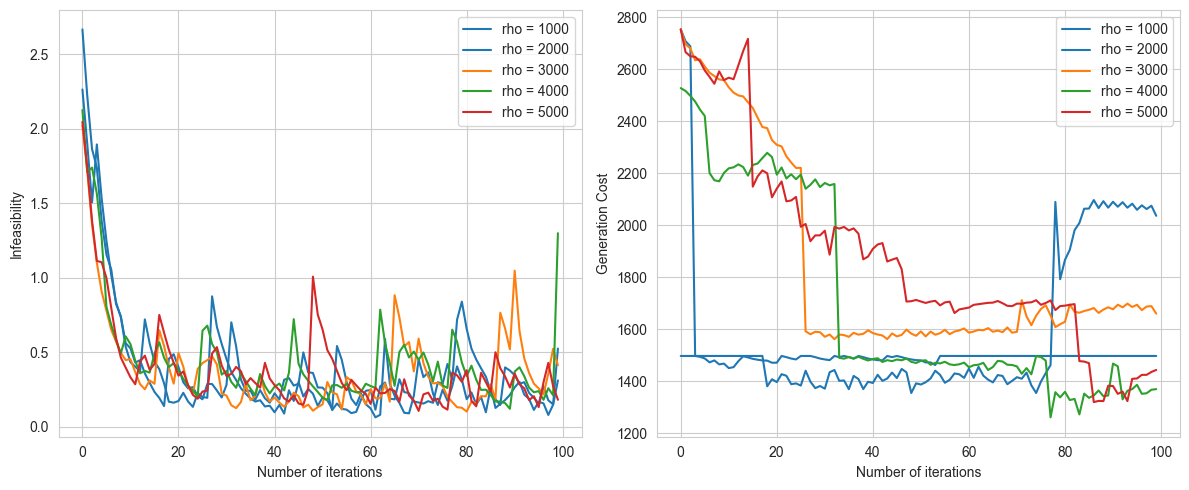

In [47]:
# Plotting each data array
labels = [f'rho = {rho_arr[i]}' for i in range(len(rho_arr))]
viridis = plt.get_cmap('tab10', 12)
colors = viridis(range(10)) #array of colors

x = [i for i in range(max_iter)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

#Plot In

for y_infea, label, color in zip(feasibility_arr, labels, colors):
    axes[0].plot(x, y_infea, label=label, color=color)

# Adding legend, labels, title, and grid
axes[0].legend()
axes[0].set_xlabel('Number of iterations')
axes[0].set_ylabel('Infeasibility')
axes[0].grid(True)


#Plot 2
#plt.subplot(1,2,2)
for y_cost, label, color in zip(gcost_arr, labels, colors):
    axes[1].plot(x, y_cost, label=label, color=color)

# Adding legend, labels, title, and grid
axes[1].legend()
axes[1].set_xlabel('Number of iterations')
axes[1].set_ylabel('Generation Cost')
axes[1].grid(True)


# Display the plot
plt.tight_layout()
plt.show()

What we can see when implementing the algorithm can get us to better results on constraint violations and sometimes on the objective function, specially when the number of nodes increases. Also, we can observe that some values for the penalty terms produce the same outcomes.The **penalty term** ($\rho$) we choose will drastically impact the divergence of the algorithm.

# Two Level ADMM

In [44]:
from ADMM_TwoLevel.twoLevel_admm import TwoLevel_ADMM_ACOPF

In [49]:
#Initialize values
d = n_bndVariables_30 * 2
beta0 = 2000
alpha0 = jnp.array(np.random.random(d))
xbar0 = generate_xbar0(x_r_arr0,idx_buses_arr,alpha0,beta0 * 2)

In [50]:
solution2 = TwoLevel_ADMM_ACOPF(net,regions,G,B,S,x_r_arr0,xbar0,idx_buses_arr,bnds_arr0,d,beta0,alpha0)

-5.189274154379135
-7.3061245494027975
-7.893438661234834
-8.187095717150854
-8.33392424510886
-8.407338509087865
-8.444045641077368
-8.462399207072119
-8.471575990069496
-8.476164381568182
-8.478458577317527
-8.479605675192198
-8.480179224129534
-8.480465998598204
-8.480609385832537
-8.480681079449703
-8.480716926258287
-8.480734849662577
-8.480743811364725
-8.480748292215798
-8.480750532641334
-8.480751652854103
-8.480752212960487
-8.480752493013677
-8.480752633040275
-8.480752703053572
-8.48075273806022
-8.480752755563547
N. Iteration for Outer Loop: 0
Number of iterationns for inner loop: 28

Constraints violation for each region
Region 1
 	-Equality constraints violation: 370.6563953168204 
 	-Inequality constraints violation: -654282.408864066
Region 2
 	-Equality constraints violation: 142.95753348701163 
 	-Inequality constraints violation: -136185.0161872857
Region 3
 	-Equality constraints violation: 140.33947464613925 
 	-Inequality constraints violation: -62867.06648353294


OverflowError: An overflow was encountered while parsing an argument to a jitted computation, whose argument path is x.


## Summary of the Approach

The ADMM implementation for the AC-OPF problem involves the following key components:

1. **Decomposition of the Global Problem:**
   - The global AC-OPF problem is decomposed into local subproblems corresponding to individual machines (generators or buses).

2. **Local Optimization:**
   - Each machine solves its own optimization problem, considering local constraints and objectives, and updates its local variables.

3. **Shared Variables and Consensus:**
   - Power flows between buses are treated as shared variables requiring consensus.
   - The orchestrator ensures that the shared variables are updated consistently across the network.

4. **Dual Variables and Augmented Lagrangian:**
   - Dual variables are used to enforce consensus constraints.
   - The augmented Lagrangian incorporates penalty terms to penalize discrepancies between local and shared variables.

5. **Iterative Updates via ADMM:**
   - The algorithm iteratively updates local variables, shared variables, and dual variables.
   - Convergence is achieved when the solutions are consistent and optimal across the entire network.

